In [1]:

# Part 1: Dataset Exploration and Setup

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
from PIL import Image

2025-05-06 12:05:39.610226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746533139.848606      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746533139.911095      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Exception ignored in: <function _xla_gc_callback at 0x7dd53fd82ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


In [3]:
# Check for GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

# Verify GPU configuration
if tf.config.list_physical_devices('GPU'):
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    for gpu in tf.config.list_physical_devices('GPU'):
        print("Name:", gpu.name, "Type:", gpu.device_type)
    
    # Configure memory growth to avoid OOM errors
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.18.0
GPU is available
Num GPUs Available:  2
Name: /physical_device:GPU:0 Type: GPU
Name: /physical_device:GPU:1 Type: GPU


In [4]:
# Set paths
DATASET_PATH = "../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
TEST_DIR = "../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"

# List the ASL classes
classes = sorted(os.listdir(DATASET_PATH))
print(f"Total classes: {len(classes)}")
print(f"Classes: {classes}")


Total classes: 29
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


Class 'A': 3000 samples
Class 'B': 3000 samples
Class 'C': 3000 samples
Class 'D': 3000 samples
Class 'E': 3000 samples
Class 'F': 3000 samples
Class 'G': 3000 samples
Class 'H': 3000 samples
Class 'I': 3000 samples
Class 'J': 3000 samples
Class 'K': 3000 samples
Class 'L': 3000 samples
Class 'M': 3000 samples
Class 'N': 3000 samples
Class 'O': 3000 samples
Class 'P': 3000 samples
Class 'Q': 3000 samples
Class 'R': 3000 samples
Class 'S': 3000 samples
Class 'T': 3000 samples
Class 'U': 3000 samples
Class 'V': 3000 samples
Class 'W': 3000 samples
Class 'X': 3000 samples
Class 'Y': 3000 samples
Class 'Z': 3000 samples
Class 'del': 3000 samples
Class 'nothing': 3000 samples
Class 'space': 3000 samples


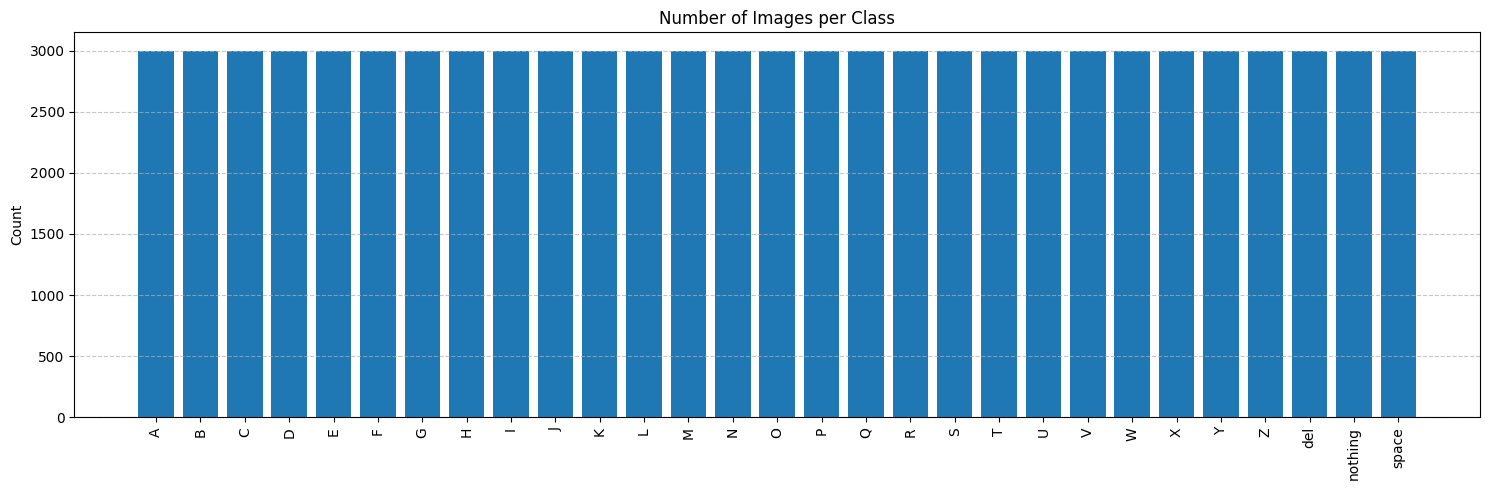

In [5]:
# Display sample count per class
samples_per_class = {}
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    count = len(os.listdir(class_path))
    samples_per_class[class_name] = count
    print(f"Class '{class_name}': {count} samples")

# Visualize class distribution
plt.figure(figsize=(15, 5))
plt.bar(samples_per_class.keys(), samples_per_class.values())
plt.xticks(rotation=90)
plt.title('Number of Images per Class')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
# Function to display random images from the dataset
def show_random_images(dataset_path, classes, num_images=3, rows=3):
    plt.figure(figsize=(15, 15))
    for i, class_name in enumerate(random.sample(classes, min(len(classes), rows))):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)
        for j in range(num_images):
            if j < len(images):
                image_path = os.path.join(class_path, random.choice(images))
                img = plt.imread(image_path)
                plt.subplot(rows, num_images, i * num_images + j + 1)
                plt.imshow(img)
                plt.title(f"{class_name}")
                plt.axis('off')
    plt.tight_layout()
    plt.show()


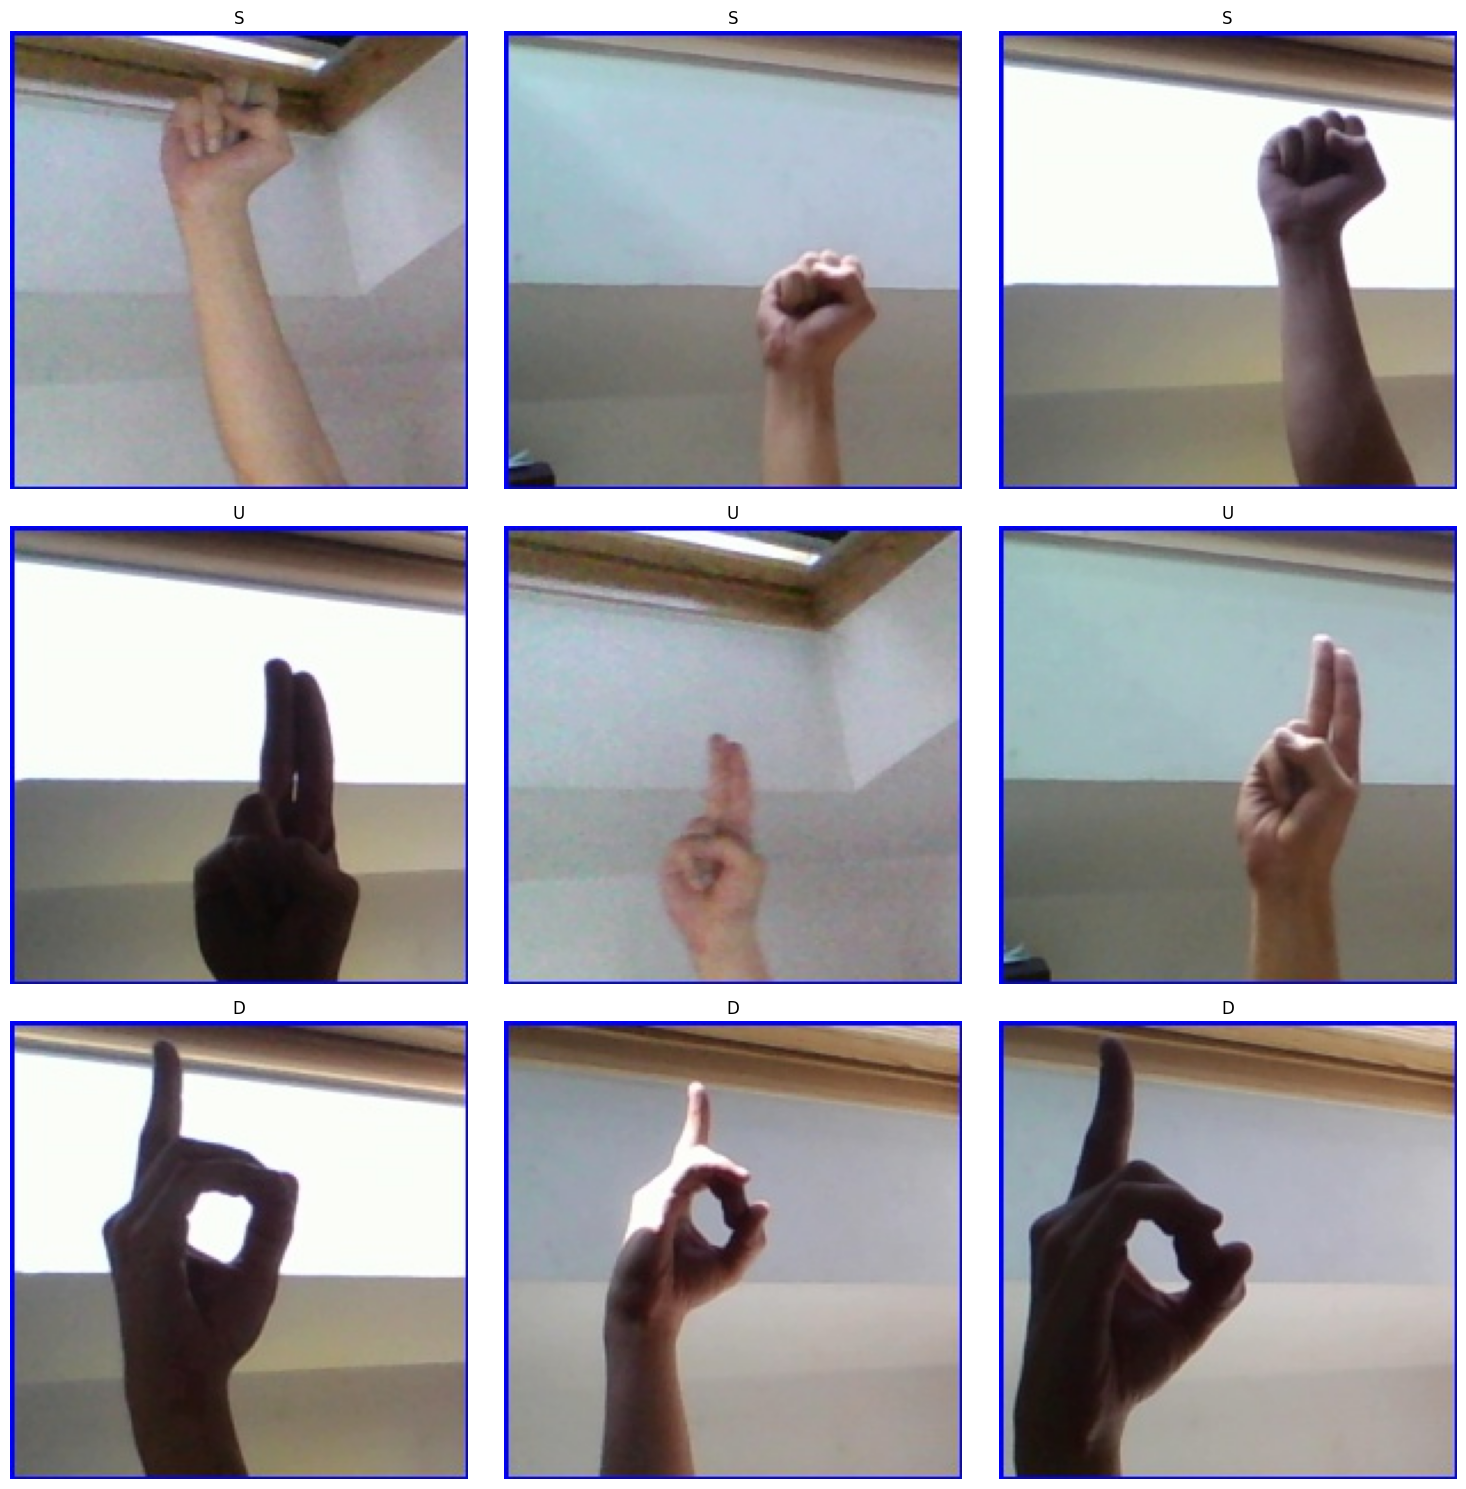

Sample image shape: (200, 200, 3)


In [8]:
# Show random samples from the dataset
show_random_images(DATASET_PATH, classes, num_images=3, rows=3)

# Let's check an image's dimensions to know what input shape we need
sample_img_path = os.path.join(DATASET_PATH, classes[0], os.listdir(os.path.join(DATASET_PATH, classes[0]))[0])
sample_img = plt.imread(sample_img_path)
print(f"Sample image shape: {sample_img.shape}")

# Define image dimensions for our model
IMG_HEIGHT, IMG_WIDTH = 64, 64  # Using smaller dimensions for faster training
BATCH_SIZE = 64

In [9]:

# Part 2: Data Preparation with Generators

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale validation data - no augmentation
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create validation generator
validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


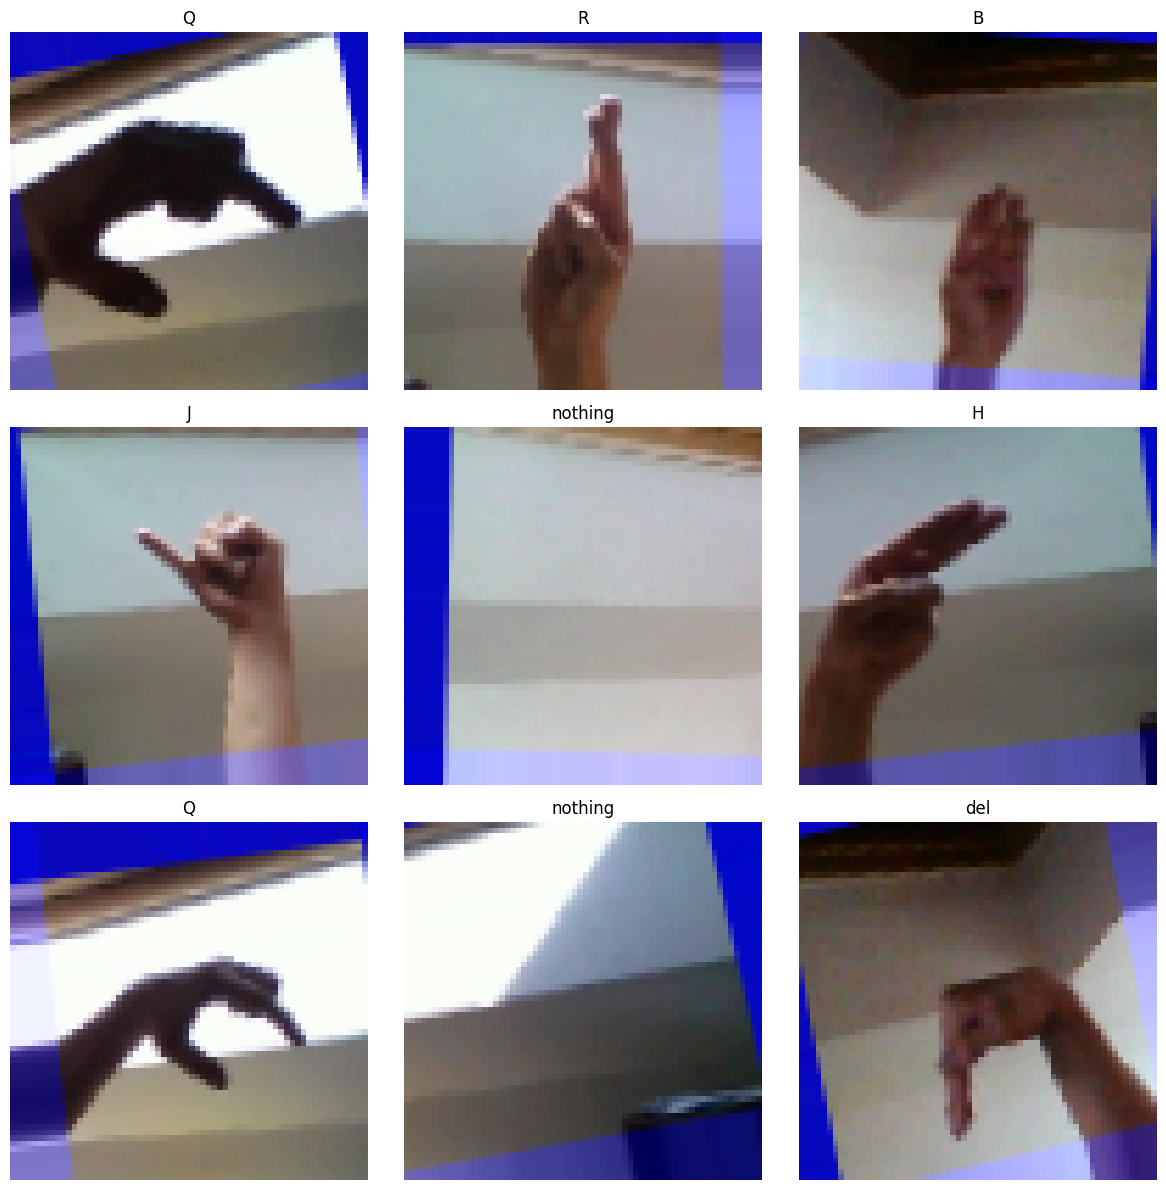

In [10]:
# Display some augmented images to see the effect
def show_augmented_images():
    # Get a batch from the training generator
    x_batch, y_batch = next(train_generator)
    
    # Display 9 augmented images
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(x_batch[i])
        class_idx = np.argmax(y_batch[i])
        class_name = list(train_generator.class_indices.keys())[class_idx]
        plt.title(f"{class_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
show_augmented_images()

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

In [11]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Class mapping: {train_generator.class_indices}")

Training samples: 69600
Validation samples: 17400
Steps per epoch: 1087
Validation steps: 271
Number of classes: 29
Class mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [12]:
# Part 3: CNN Model Architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [13]:
def create_asl_model(input_shape, num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Flatten and Dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746533250.139940      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746533250.140609      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,500,541 (17.17 MB)

 Trainable params: 4,498,621 (17.16 MB)

 Non-trainable params: 1,920 (7.50 KB)

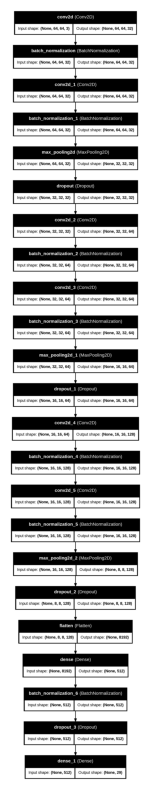

In [14]:
# Create the model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)  # RGB images
num_classes = len(train_generator.class_indices)
model = create_asl_model(input_shape, num_classes)

# Display the model summary
model.summary()

# Visualize the model architecture (optional)
from tensorflow.keras.utils import plot_model
try:
    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(plt.imread('model_architecture.png'))
    plt.axis('off')
    plt.show()
except Exception as e:
    print(f"Could not visualize model architecture: {e}")

In [15]:
# Part 4: Model Training with Callbacks

import time
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

# Create checkpoint callback to save the best model
checkpoint = ModelCheckpoint(
    'asl_model_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when training plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [16]:
# TensorBoard callback for visualization
tensorboard = TensorBoard(
    log_dir=f'./logs/{time.strftime("%Y%m%d-%H%M%S")}',
    histogram_freq=1
)

# Combine all callbacks
callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

# Set the number of epochs
EPOCHS = 30

In [17]:
# Part 4: Model Training with Callbacks

import time
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

# Create checkpoint callback to save the best model
checkpoint = ModelCheckpoint(
    'asl_model_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when training plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# TensorBoard callback for visualization
tensorboard = TensorBoard(
    log_dir=f'./logs/{time.strftime("%Y%m%d-%H%M%S")}',
    histogram_freq=1
)

# Combine all callbacks
callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

# Set the number of epochs
EPOCHS = 30

# Function to run training with GPU performance metrics
def train_with_gpu_metrics():
    # Start timer
    start_time = time.time()
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    # Calculate training time
    training_time = time.time() - start_time
    hours, remainder = divmod(training_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Total training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")
    
    return history

# Run training
history = train_with_gpu_metrics()

# Save the final model
model.save('asl_model_final.keras')
print("Model saved successfully!")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746533277.796543     113 service.cc:148] XLA service 0x7dd43c010190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746533277.797374     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746533277.797393     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746533278.551409     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746533286.663724     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.3682 - loss: 2.3467

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.29180, saving model to asl_model_best.keras
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 778s 696ms/step - accuracy: 0.3684 - loss: 2.3459 - val_accuracy: 0.2918 - val_loss: 4.1185 - learning_rate: 0.0010
Epoch 2/30
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.8906 - loss: 0.4595

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.29180
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8906 - loss: 0.4595 - val_accuracy: 0.0000e+00 - val_loss: 7.2230 - learning_rate: 0.0010
Epoch 3/30
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8605 - loss: 0.4087
Epoch 3: val_accuracy improved from 0.29180 to 0.77243, saving model to asl_model_best.keras
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 253s 231ms/step - accuracy: 0.8606 - loss: 0.4086 - val_accuracy: 0.7724 - val_loss: 0.8954 - learning_rate: 0.0010
Epoch 4/30
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - accuracy: 0.9531 - loss: 0.1460
Epoch 4: val_accuracy improved from 0.77243 to 1.00000, saving model to asl_model_best.keras
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9531 - loss: 0.1460 - val_accuracy: 1.0000 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 5/30
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9363 - loss: 0.1837
Epoch 5: val_accuracy did not improve from 1.00000
1087

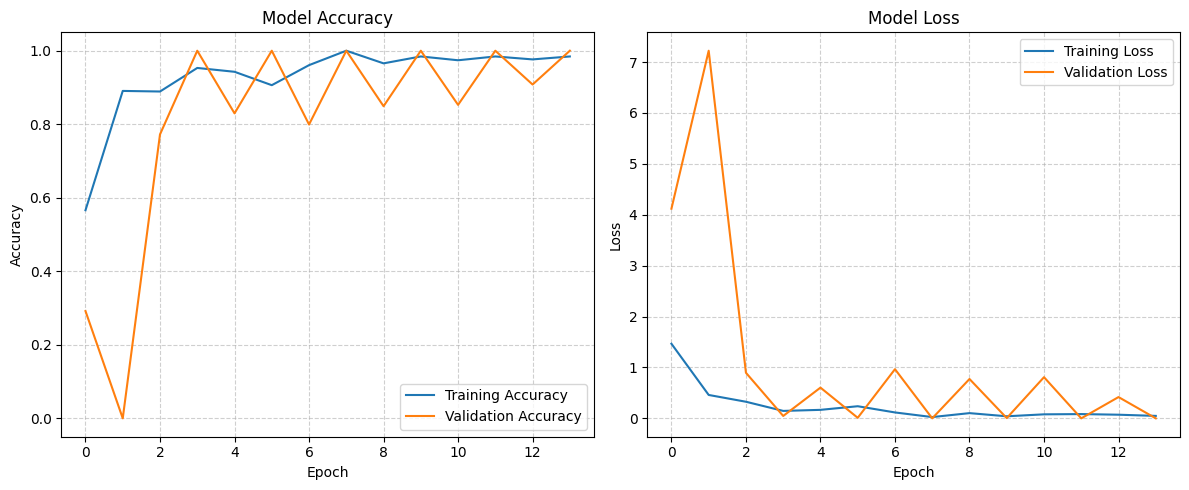

In [18]:

# Part 5: Model Evaluation and Visualization

# Plot training history
def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [21]:
# Get predictions for validation data
validation_generator.reset()
y_pred = model.predict(
    validation_generator,
    steps=validation_steps,
    verbose=1
)

# Get true labels
y_true = validation_generator.classes

# Convert predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

271/271 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step


In [25]:
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred_classes: {len(y_pred_classes)}")

Length of y_true: 17400
Length of y_pred_classes: 17344


In [26]:
# Ensure predictions cover the entire validation set
y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get ground truth labels
y_true = validation_generator.classes[:len(y_pred_classes)]  # Match the length of predictions

272/272 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step


In [27]:
# Calculate evaluation metrics
from sklearn.metrics import classification_report, accuracy_score

# Get class names
class_names = list(validation_generator.class_indices.keys())

# Print accuracy
print(f"Validation Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Validation Accuracy: 0.7740

Classification Report:
              precision    recall  f1-score   support

           A       0.54      1.00      0.71       600
           B       0.96      0.97      0.97       600
           C       0.82      1.00      0.90       600
           D       0.97      0.79      0.87       600
           E       0.92      0.44      0.60       600
           F       0.90      1.00      0.95       600
           G       0.83      0.79      0.81       600
           H       0.79      0.98      0.88       600
           I       1.00      0.47      0.63       600
           J       0.87      0.82      0.85       600
           K       0.94      1.00      0.97       600
           L       0.99      1.00      0.99       600
           M       0.57      0.83      0.68       600
           N       0.28      0.45      0.35       600
           O       0.99      0.59      0.74       600
           P       0.86      1.00      0.93       600
           Q       0.68      

In [28]:
# Plot confusion matrix (showing only a subset if there are many classes)
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

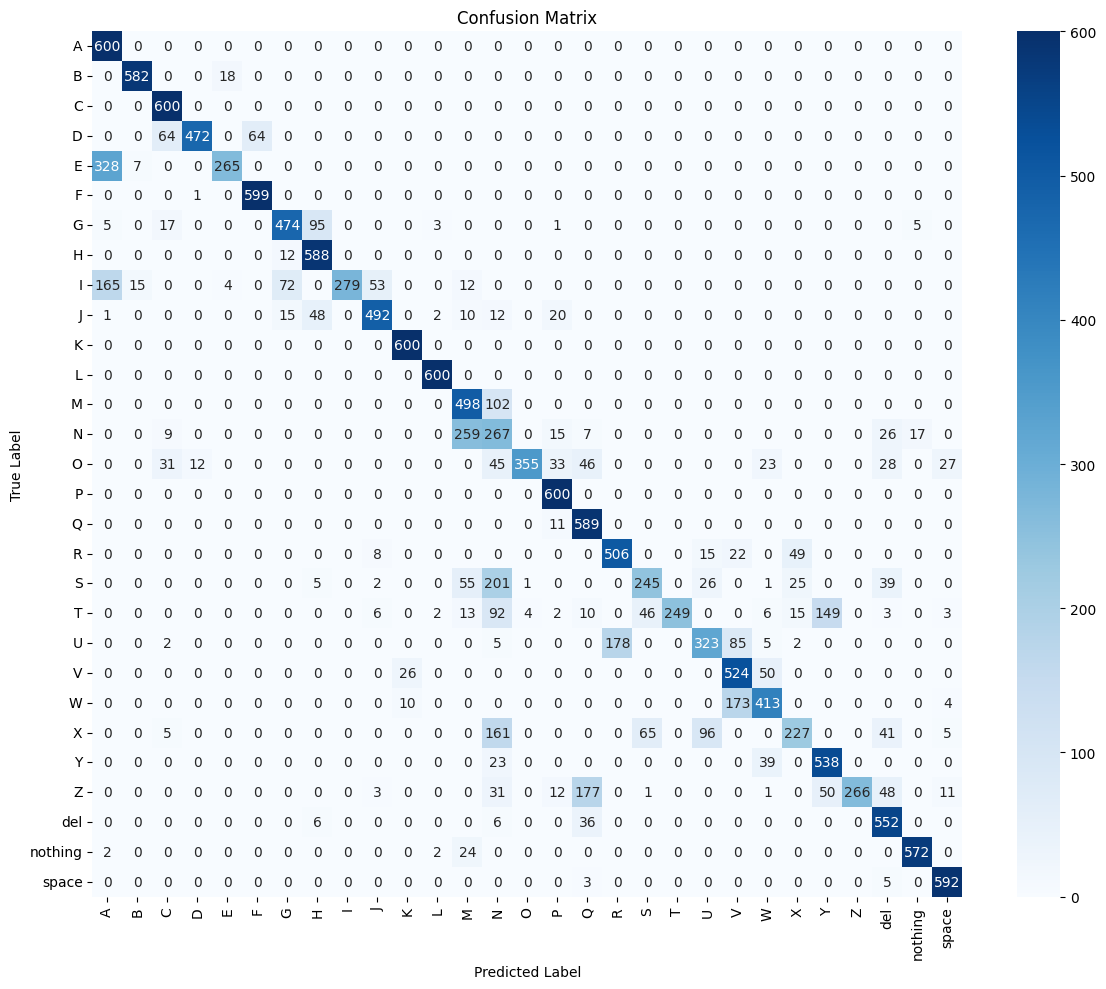

In [29]:
# Visualize confusion matrix (if not too many classes)
if len(class_names) <= 30:  # Only show full matrix if not too many classes
    plot_confusion_matrix(y_true, y_pred_classes, class_names)
else:
    # Show confusion matrix for a subset of classes
    subset_indices = list(range(10))  # First 10 classes
    mask_true = np.isin(y_true, subset_indices)
    mask_pred = np.isin(y_pred_classes, subset_indices)
    mask = mask_true & mask_pred
    
    plot_confusion_matrix(
        y_true[mask], 
        y_pred_classes[mask],
        [class_names[i] for i in subset_indices]
    )
    print("Note: Showing confusion matrix for first 10 classes only due to large number of classes")

In [31]:
# Part 6: Testing on New Images

from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to predict a single image
def predict_image(model, img_path, class_names):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(img_path)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]
    
    # Return results
    return predicted_class, confidence, predictions[0]

# Function to visualize prediction with top-n classes
def visualize_prediction(img_path, predictions, class_names, top_n=5):
    # Load the image
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    
    # Get top-n predictions
    top_indices = np.argsort(predictions)[-top_n:][::-1]
    top_classes = [class_names[i] for i in top_indices]
    top_probs = [predictions[i] for i in top_indices]
    
    # Plot
    plt.figure(figsize=(12, 5))
    
    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Prediction: {top_classes[0]}")
    plt.axis('off')
    
    # Show bar chart of top predictions
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(top_classes))
    plt.barh(y_pos, top_probs, align='center')
    plt.yticks(y_pos, top_classes)
    plt.xlabel('Probability')
    plt.title('Top Predictions')
    
    plt.tight_layout()
    plt.show()

In [32]:
# Test on random images from the test directory
def test_random_images(test_dir, model, class_names, num_images=5):
    # Get test images
    test_images = []
    for img_name in os.listdir(test_dir):
        if img_name.endswith(('.jpg', '.jpeg', '.png')):
            test_images.append(os.path.join(test_dir, img_name))
    
    # Select random images
    if len(test_images) > num_images:
        test_images = random.sample(test_images, num_images)
    
    # Test each image
    for img_path in test_images:
        predicted_class, confidence, predictions = predict_image(model, img_path, class_names)
        print(f"Image: {os.path.basename(img_path)}")
        print(f"Predicted: {predicted_class} with {confidence:.2%} confidence")
        visualize_prediction(img_path, predictions, class_names)
        print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: M_test.jpg
Predicted: M with 86.55% confidence


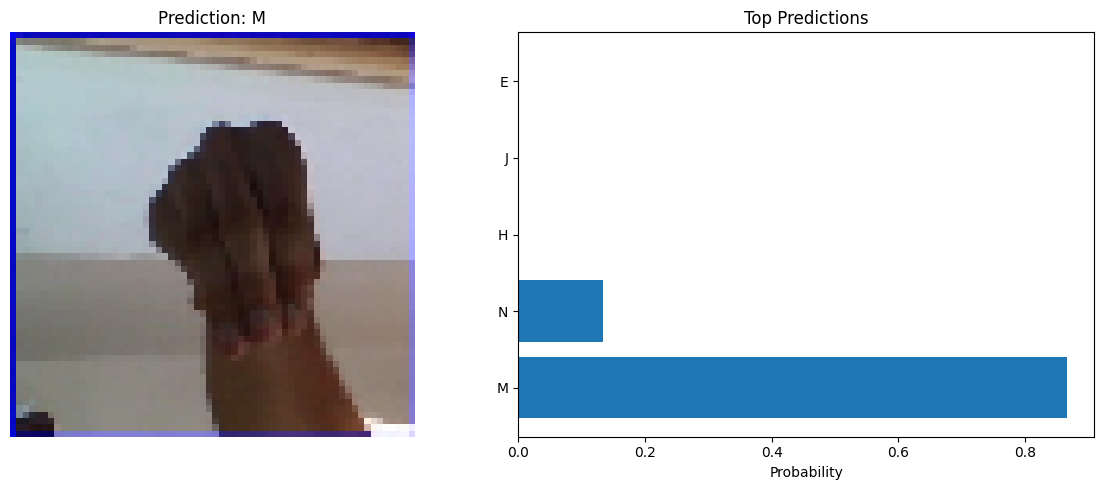

--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: I_test.jpg
Predicted: I with 99.94% confidence


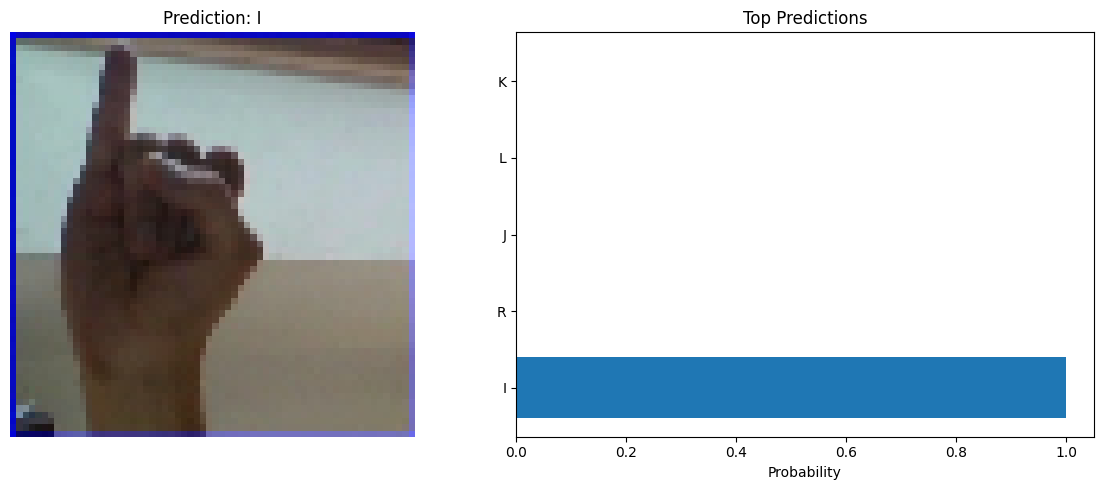

--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: J_test.jpg
Predicted: J with 99.71% confidence


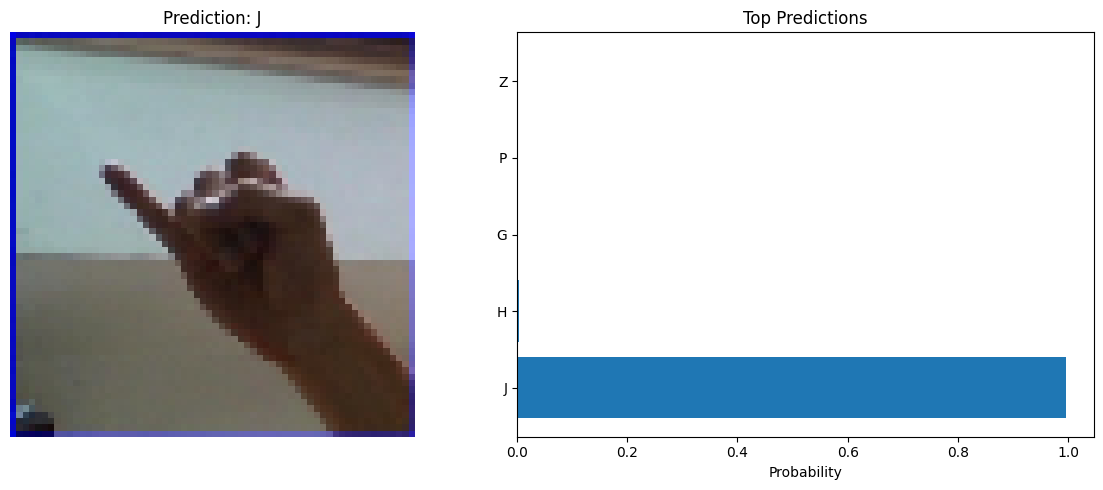

--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: L_test.jpg
Predicted: L with 100.00% confidence


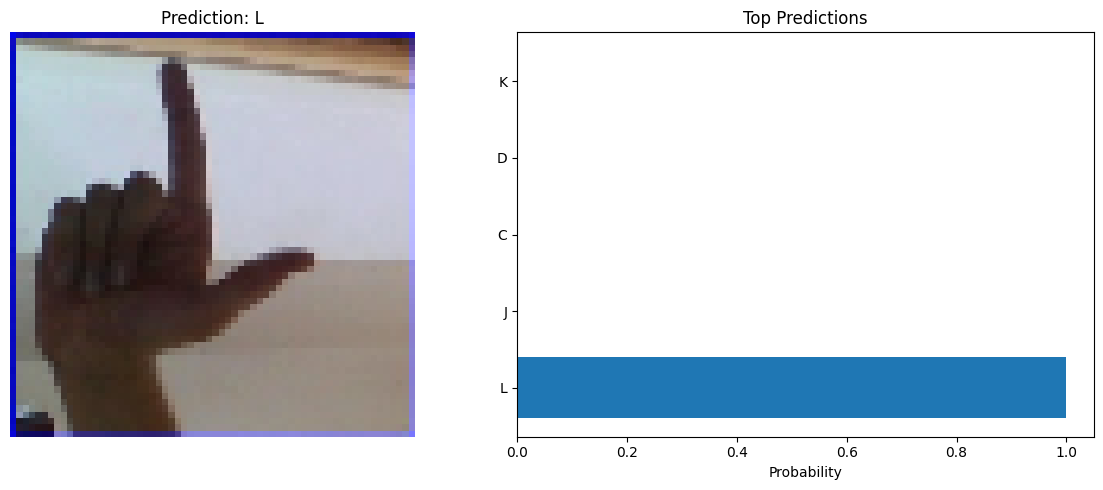

--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: B_test.jpg
Predicted: B with 99.99% confidence


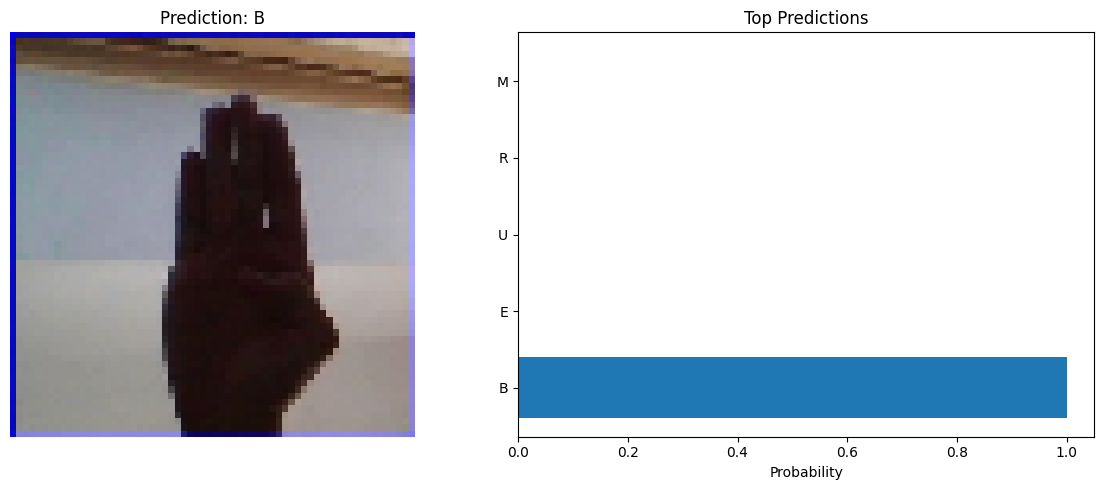

--------------------------------------------------


In [33]:
# Get class names (indices to class names mapping)
class_names = list(train_generator.class_indices.keys())

# Test some random images
if os.path.exists(TEST_DIR):
    test_random_images(TEST_DIR, model, class_names, num_images=5)
else:
    print(f"Test directory {TEST_DIR} not found. Skipping test images visualization.")
    
    # Alternative: test on some validation images
    print("Testing on a few validation images instead:")
    validation_generator.reset()
    for _ in range(5):
        batch_x, batch_y = next(validation_generator)
        img_array = batch_x[0:1]  # Take the first image from batch
        true_label = np.argmax(batch_y[0])
        true_class = class_names[true_label]
        
        # Make prediction
        predictions = model.predict(img_array)
        predicted_class_idx = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_idx]
        confidence = predictions[0][predicted_class_idx]
        
        # Display results
        plt.figure(figsize=(6, 6))
        plt.imshow(img_array[0])
        plt.title(f"True: {true_class}\nPredicted: {predicted_class} ({confidence:.2%})")
        plt.axis('off')
        plt.show()
        
        print(f"True Class: {true_class}")
        print(f"Predicted: {predicted_class} with {confidence:.2%} confidence")
        print("-" * 50)